# Lab 05 &mdash; $\chi^2$-test and non-parametric methods

## Roadmap

* [$\chi^2$-test for independence](#%24\chi^2%24-test-for-independence)
    * [Interpretation](#Interpretation)
* [Testing goodness of fit](#Testing-goodness-of-fit)
    * [$\chi^2$-test for GoF](#chi2-test-for-GoF)
    * [Kolmogorov-Smirnov test](#Kolmogorov-Smirnov-test)
* [Sign test](#Sign-test)
* [U test](#U-test)
* [Bootstrap](#Bootstrap)
    * [Bootstrap confidence intervals](#Bootstrap-confidence-intervals)
    * [Bootstrap p-values](#Bootstrap-p-values)

## $\chi^2$-test for independence

We will apply the $\chi^2$-test for independence on a case study of A/B testing from <a href="https://www.datacamp.com/projects/184">Datacamp</a>. This section is adapted from [this notebook](https://www.kaggle.com/yufengsui/datacamp-project-mobile-games-a-b-testing). 
The dataset contains results on A/B testing for a mobile game called <a href="https://www.facebook.com/cookiecatsgame">Cookie Cats</a>, which is a popular mobile puzzle game developed by <a href="http://tactile.dk">Tactile Entertainment</a>.

It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level. It also features singing cats. Check out this short demo:</p>
<p><a href="https://youtu.be/GaP5f0jVTWE"><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/cookie_cats_video.jpeg" style="width: 500px"></a></p>




As players progress through the levels of the game, they will **occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress**. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.

But where should the gates be placed? Initially the first gate was placed at level 30. **We're going to analyze an AB-test where we moved the first gate in Cookie Cats from level 30 to level 40.**

<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/cc_gates.png" style="width: 500px"></p>

In particular, we will use a $\chi^2$ test to evaluate the impact of the gate location on player retention. The data contains two categorical variables:
* `retention_1`: did the player come back and play 1 day after installing?
* `retention_7`: did the player come back and play 7 days after installing?

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# let's load the dataset and print a preview
# available at https://moodle.royalholloway.ac.uk/mod/resource/view.php?id=455845
df_cookie = pd.read_csv("cookie_cats.csv")
df_cookie.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


* Now we want to establish whether the gate location has a significant effect on the 1-day retention rate
* We first build a contingency table where the input factor is the version of the game, and the output is the 1-day retention

In [3]:
cookie_1_contable = pd.crosstab(index=df_cookie.version, columns=df_cookie.retention_1)
cookie_1_contable

retention_1,False,True
version,,
gate_30,24666,20034
gate_40,25370,20119


Now we apply `scipy.stats` function `chi2_contingency` which takes in input a 2-d array (a contingency table) and returns the value of the test statistic, p-value, degrees of freedom, and array of expected counts under the null (independence). 

In [4]:
# parameter correction applies Yates’ correction for continuity. 
# we set it to false here
chi2, p_val, dof, exp_counts = stats.chi2_contingency(cookie_1_contable, correction=False)
print("the value of the test statistic is "+str(chi2)+". p value is: "+str(p_val))
print("Degrees of freedom: "+str(dof))
print("Expected counts under the null: ")
print(exp_counts)

the value of the test statistic is 3.182963657512031. p value is: 0.07440965529692188
Degrees of freedom: 1
Expected counts under the null: 
[[24799.13514952 19900.86485048]
 [25236.86485048 20252.13514952]]


* We didn't obtain a very small p-value ($p>0.05$), so there might not be a real effect on the 1-day retention rate. I.e., we don't have enough evidence to reject the null hypothesis that `version` and `retention_1` are independent 
* However, since players have only been playing the game for one day, it is likely that most players haven't reached level 30 yet. That is, many players won't have been affected by the gate, even if it's as early as level 30. 
* So let's now evaluate the effect on the 7-day retention rate

In [5]:
cookie_7_contable = pd.crosstab(index=df_cookie.version, columns=df_cookie.retention_7)
cookie_7_contable

retention_7,False,True
version,,
gate_30,36198,8502
gate_40,37210,8279


In [6]:
chi2_7, p_val_7, dof_7, exp_counts_7 = stats.chi2_contingency(cookie_7_contable, correction=False)
print("For the 7-day retention rate, value of the test statistic is "+str(chi2_7)+". p value is: "+str(p_val_7))
print("Degrees of freedom: "+str(dof_7))
print("Expected counts under the null: ")
print(exp_counts_7)

For the 7-day retention rate, value of the test statistic is 10.013167328688969. p value is: 0.0015542499756142805
Degrees of freedom: 1
Expected counts under the null: 
[[36382.90257127  8317.09742873]
 [37025.09742873  8463.90257127]]


Here the difference is significant ($p\approx 0.00155$). 

The `statsmodel` library also offers methods to analyze contingency tables through the `Table` class. See more at https://www.statsmodels.org/stable/generated/statsmodels.stats.contingency_tables.Table.html
* It contains attributes for the expected counts and standardized residuals, among others

In [7]:
# generate a Table object giving in input the contingency table (a 2-d array)
sm_table = sm.stats.Table(cookie_7_contable)
# attribute fittedvalues gives the expected count under the null
print("Expected counts:")
print(sm_table.fittedvalues)
# attribute chi2_contribs gives the contribution of each cell to the chi-square statistic
print("Chi-square statistic contributions:")
print(sm_table.chi2_contribs)
# attribute resid_pearson gives the standardized residuals
print("Standardized residuals:")
print(sm_table.resid_pearson)

Expected counts:
retention_7         False        True 
version                               
gate_30      36382.902571  8317.097429
gate_40      37025.097429  8463.902571
Chi-square statistic contributions:
retention_7     False     True 
version                        
gate_30      0.939699  4.110684
gate_40      0.923400  4.039385
Standardized residuals:
retention_7     False     True 
version                        
gate_30     -0.969380  2.027482
gate_40      0.960937 -2.009822


To perform the actual $\chi^2$-test, we invoke the `test_nominal_association` function of the `Table` object. It returns a tuple with attributes `df`, `pvalue` and `statistic`

In [8]:
rslt = sm_table.test_nominal_association()
print(rslt)

df          1
pvalue      0.0015542499756142636
statistic   10.013167328688969


### Interpretation

We saw that there is a significant association between `gate` and `retention_7`. Let's quantify the efffect by computing manually Cramer's $V$ for both 1-day and 7-day cases. Recall that this is equals to
$$V = \sqrt{\frac{\chi^2}{\min(r-1,c-1)\cdot n}}$$

In [9]:
# let's define a function that takes in input the contingency table (2-d array)
# and does all the rest
def Cramer_V(cont_table):
    # total number of observations
    n = np.sum(np.sum(cont_table))
    # number of rows and columns
    r = cont_table.shape[0]
    c = cont_table.shape[1]
    # compute chi-square statistic, via e.g. scipy.stats
    chi2_stat, _, _, _ = stats.chi2_contingency(cont_table, correction=False)
    return np.sqrt(chi2_stat/(np.min([r-1,c-1])*n))

In [10]:
print("Cramer's V for the 1-day case is: "+str(Cramer_V(cookie_1_contable)))
print("Cramer's V for the 7-day case is: "+str(Cramer_V(cookie_7_contable)))

Cramer's V for the 1-day case is: 0.005940719598467412
Cramer's V for the 7-day case is: 0.010536805199357699


Since `statsmodels`' `Table` provides us with easy-to-use standardized residuals, we can perform ___post-hoc Z tests___ on the residuals to see which individual cell exhibit a significant difference from the expected count.
* Recall that standardized residuals are already Z values, so we need to compute the p-values "manually" (because `statsmodels`'s `ztest` function requires in input the samples)
* and we need to apply some correction for multiple tests of course

In [11]:
# let's perform post-hoc two-sided Z tests for the cells in the 2nd column 
# of sm_table (i.e., the Table object for the retain_7 case)

# overall (family-wise) significance is alpha
alpha = 0.05

# standardized residuals
std_res=sm_table.resid_pearson
print("Standardized residuals (only 2nd column):")
print(std_res.iloc[:,1])

# we have two ways here:
# 1. compare the Z values (std. residuals) with the appropriate critical Z values (as done in lectures)
# 2. compute p values and correct them later via sm.stats.multipletests

# method 1.
# corrected alpha (via Bonferroni) is alpha/num_tests. 
# here we test only the cells in the second column, so num_tests=num_rows
# then, since it's a two-sided test, we need to divide by two the corrected significance
n_rows = std_res.shape[0]
alpha_cor = alpha/n_rows

# critical value at alpha_cor/2 (recall, we use the ppf method of Z distribution)
z_critical = stats.norm.ppf(alpha_cor/2)
print("Critical value: "+str(z_critical))

# the above will be negative, but we take absolute values below, so we don't care
# we compare each residual with the above. 
# If above the critical value, difference is significant 
print(np.abs(std_res.iloc[:,1])>=np.abs(z_critical))

Standardized residuals (only 2nd column):
version
gate_30    2.027482
gate_40   -2.009822
Name: True, dtype: float64
Critical value: -2.241402727604945
version
gate_30    False
gate_40    False
Name: True, dtype: bool


This is a very interesting example showing that even though the $\chi^2$-test establishes a statistically significant result, the individual counts are not significantly different from the expected counts. With such results, we need to be careful with our claims!

In [12]:
# method 2.
# compute the two-sided p-values
# in the code below, we take the min between left-tailed and right-tailed probabilities, as usual
pvalues = 2*np.min([stats.norm.cdf(std_res.iloc[:,1]), 1-stats.norm.cdf(std_res.iloc[:,1])], axis=0)
print("uncorrected p-values: "+str(pvalues))
# use bonferroni correction within sm.stats.multipletests function 
# (other correction  methods are possible)
rejected, correct_pvals, _, _ = sm.stats.multipletests(pvalues, alpha=alpha, method='bonferroni')
print("tests rejected? "+str(rejected))
print("corrected p-values: "+str(correct_pvals))

uncorrected p-values: [0.04261312 0.04445002]
tests rejected? [False False]
corrected p-values: [0.08522624 0.08890004]


## Testing goodness-of-fit

### chi2-test for GoF
* We saw that the $\chi^2$-test for independence can be adapted to compare an empirical discrete distribution with an a-priori model
* `scipy.stats` offers a method `chisquare` for doing exactly that. It takes in input two parameters `f_obs` (observed counts) and `f_exp` (expected counts, those under the a priori model)
* Let's make an experiment where we generate the observations from the a priori model, some binomial, manipulate the observations and check whether or not the manipulated dataset still fits well the original model

In [13]:
# the a-priori model, a binomial with parameters n=10 and p=0.3
n = 10
apriori_dist = stats.binom(n=n,p=0.3)
# the expected frequencies are given by the pmf of apriori_dist 
exp_frequencies = [apriori_dist.pmf(k) for k in range(n+1)]
print("Expected frequencies: "+str(exp_frequencies))

Expected frequencies: [0.028247524900000005, 0.12106082100000018, 0.2334744405, 0.26682793200000016, 0.20012094900000013, 0.10291934520000007, 0.03675690899999999, 0.009001692000000002, 0.0014467004999999982, 0.00013778100000000015, 5.904899999999995e-06]


In [14]:
# generate a random sample of size 1000 from this binomial
sample_size=1000
my_sample = apriori_dist.rvs(sample_size)
# manipulate the sample, by adding a uniform integer between -2 and 2 (and clipping to 0-10)
low = -2
high = 2
my_sample = my_sample + stats.randint(low,high+1).rvs(np.shape(my_sample))
# clip the result
my_sample[my_sample>10]=10
my_sample[my_sample<0]=0

# let's now compute the corresponding observed frequencies
obs_frequencies = [np.mean(my_sample==k) for k in range(n+1)]
print("the observed frequencies (of the manipulated) sample are:")
print(obs_frequencies)

the observed frequencies (of the manipulated) sample are:
[0.109, 0.122, 0.175, 0.19, 0.192, 0.104, 0.069, 0.029, 0.009, 0.001, 0.0]


In [15]:
# finally, let's apply the chi-square test for GoF
# here we need to use expected and observed counts, 
# which we simply obtain by multiplying the frequencies by 1000 (the size of our sample)
obs_counts = np.full(np.shape(obs_frequencies), sample_size)*obs_frequencies
exp_counts = np.full(np.shape(exp_frequencies), sample_size)*exp_frequencies

print(obs_counts)
chi2stat, pval = stats.chisquare(f_obs=obs_counts,f_exp=exp_counts)
print("p-value: "+str(pval))

[109. 122. 175. 190. 192. 104.  69.  29.   9.   1.   0.]
p-value: 1.1359525009004379e-76


Such a low p-value indicate that the fit is bad (observed and expected counts are significantly different)

### Kolmogorov-Smirnov test

* The KS test is a ___non-parametric method___ to test for GoF with continuous distributions/variables
* `scipy.stats` offers methods for both 1-sample and 2-sample KS test
    * `statsmodels` function `kstest_fit` (https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.kstest_fit.html) can be applied only when the a priori model is normal or exponential
* for the 1-sample test, we will draw a sample from an exponential distribution, say $\mathbf{x}_1$, and test fit with this model
* for the 2-sample test, we will draw a sample from an exponential distribution, , say $\mathbf{x}_2$, manipulate it, and compare it with $\mathbf{x}_1$

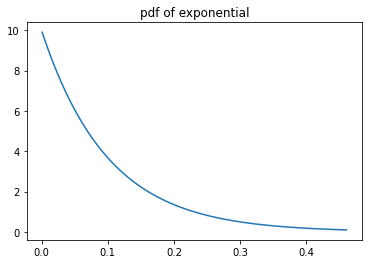

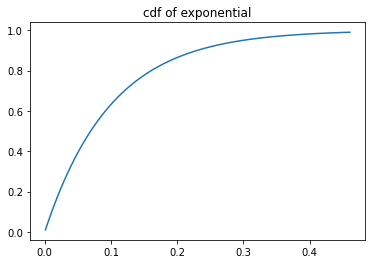

In [16]:
# our a priori model
priori_model = stats.expon(scale=1/10)

# print pdf and cdf
xs=np.linspace(priori_model.ppf(0.01),priori_model.ppf(0.99),100)
plt.plot(xs,priori_model.pdf(xs))
plt.title('pdf of exponential')
plt.show()

plt.plot(xs,priori_model.cdf(xs))
plt.title('cdf of exponential')
plt.show()

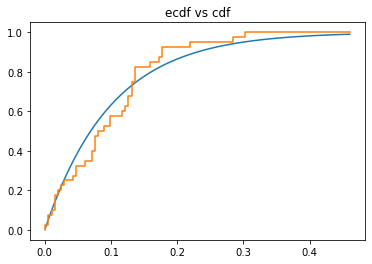

In [17]:
# now draw our sample x1 from the model
# use 40 obs
n = 40
x1 = priori_model.rvs(n)

# let's plot the empirical CDF of our sample
# and compare it with the model
# note that we use np.mean(x1<=x), i.e., 
# the proportion of x1 observations <= x, i.e., 
# the empirical cdf
ecdf_x1 = [np.mean(x1<=x) for x in xs]
plt.plot(xs,priori_model.cdf(xs))
# we use a step plot because it's discrete
plt.step(xs,ecdf_x1)
# or could have used seaborn ecdfplot, see https://seaborn.pydata.org/generated/seaborn.ecdfplot.html
plt.title('ecdf vs cdf')
plt.show()

In [18]:
# now let's perform the 1-sample ks test

# stats.ks_1samp takes in input the one sample (argument x), the cdf function of our model (argument cdf), and the direction of the test
# it returns the KS statistic and the p-value
# see more at https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_1samp.html
#KS_stat, p_val = stats.ks_1samp(x=x1, cdf=priori_model.cdf)

# NOTE: since scipy 1.8, ks_1samp is deprecate and replaced with kstest, as shown below:
KS_stat, p_val = stats.kstest(rvs=x1, cdf=priori_model.cdf)
print("p-value: "+str(p_val))

p-value: 0.22429406312743716


As expected we obtain a high p-value, indicating validity of the null hypothesis (a priori distribution = distribution of our sample) 

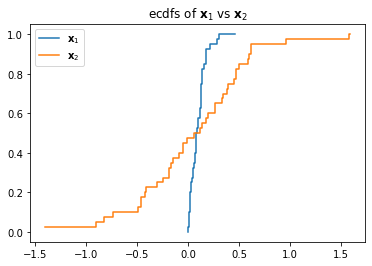

In [19]:
# now let's generate a second sample, and manipulate it by adding some "non-white" noise
x2 = priori_model.rvs(n)
# manipulate it by adding white gaussian noise (mean 0 and std 0.5)
x2 = x2 + stats.norm(loc=0,scale=0.5).rvs(n)

# compare the ecdfs of x1 and x2
# (x2 will have a different range of values than x1)
xs2 = np.arange(np.min(x2), np.max(x2)+0.01, 0.01)
ecdf_x2 = [np.mean(x2<=x) for x in xs2]
# plot them
plt.step(xs,ecdf_x1)
plt.step(xs2,ecdf_x2)
# or could have used seaborn ecdfplot, see https://seaborn.pydata.org/generated/seaborn.ecdfplot.html
plt.title('ecdfs of $\mathbf{x}_1$ vs $\mathbf{x}_2$')
plt.legend(['$\mathbf{x}_1$','$\mathbf{x}_2$'])
plt.show()

In [20]:
# now perform a 2-sample KS test (see more at https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html)
_, p_val_2sample = stats.ks_2samp(x1, x2)
print("p-value: "+str(p_val_2sample))

p-value: 0.00018791118070078278


We now see that the p-value is much smaller, which strongly supports the alternative hypothesis of the two distributions being different (as expected)

## Sign test
* We saw the sign test to do inference about one-sample median and median of paired samples (to test if there are significant differences)
* So it's the non-parametric equivalent of the one-sample T test / paired two-sample T test
    * Recall, the null is that the true median is $m_0$
    * the test statistic is the number of observations (or paired differences) above $m_0$
    * the statistic distribution under the null is a binomial with $p=1/2$
    * we saw how to adapt the test to other quantiles, but we skip this for now
* We can easily implement our own sign test
    * `scipy.stats` includes Wilcoxon signed-rank test, but this test makes more assumptions (see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html)

In [21]:
# the function takes in input one sample (which could be paired differences),
# the null value of the median, and returns the test statistic and p-value
# by default applies a two-sided test and randomly resolves ties (see lectures)
def sign_test(sample, m0=0):
    n = sample.size
    h0_distr = stats.binom(n=n,p=0.5)
    num_wins = np.sum(sample>m0)
    num_ties = np.sum(sample==m0)
    # random tie resolution corresponds to drawing
    # a coin (a 0.5 bernoulli) for each tie, i.e., 
    # drawing one binomial observation with parameters 
    # n=num_ties and p=0.5
    stat_val = num_wins + stats.binom(n=num_ties, p=0.5).rvs(1)
    left_tail_p = h0_distr.cdf(stat_val)
    # as usual, for discrete vars, P(X>=x)=1-P(X<x))=1-P(X<=x-1) 
    right_tail_p = 1 - h0_distr.cdf(stat_val-1)
    p_val=2*np.min([left_tail_p,right_tail_p])
    return stat_val, p_val

* Let's look into the same example we used for the paired two-sample T test in Lab 4. 
* In CDC BRFSS survey dataset, we have, for each individual, two variables, weight and desired weight, to which we apply a (paired) two-sample sign test using our implementation

In [22]:
# load the CDC BRFSS survey dataset and take a random sample of 50 observations
df_cdc = pd.read_csv("cdc.csv")
n_cdc = 50
df_cdc_sample = df_cdc.sample(n_cdc)
# compute the pairwise differences between weight and wtdesire
w_diff = df_cdc_sample.weight-df_cdc_sample.wtdesire

In [23]:
# let's apply our sign test implementation with m0=0 (default)
# i.e., to test the null hypothesis that it is equally probable to observe a positive and a negative difference
stat_val, p_val = sign_test(w_diff)
print("Test statistic value (num of positive differences with random tie correction): "+str(stat_val))
print("p-value: "+str(p_val))

Test statistic value (num of positive differences with random tie correction): [42]
p-value: 1.163555804595262e-06


Strong evidence in favour of the alternative hypothesis that there is a difference between weight and desired weight

## U test

* Mann-Whitney U test allows us to test whether two independent samples have the same distribution or one stochastically dominates the other
    * So it's the non-parametric equivalent of Welch's T test
* `scipy.stats` includes function `mannwhitneyu`, which uses a normal approximation of the null distribution, see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html
* Let's repeat the same experiment as above, but this time, we sample from columns weight and desired weight independently, thereby obtaining two independent samples

In [24]:
# draw independent samples of 50 observations each from weight and wtdesire columns
n = 50
weights = df_cdc.weight.sample(n)
desired_weights = df_cdc.wtdesire.sample(n)

In [25]:
U_stat, p_val = stats.mannwhitneyu(weights,desired_weights,alternative='two-sided')
print("p-value (independent samples): "+str(p_val))

p-value (independent samples): 0.019351505376525725


* We see that the p-value is much higher than in paired case, which would suggest absence of a difference between weight and desired weight
* The reason is that by treating these observations as independent, we introduce a lot of inter-subject variability
    * the variability of weights is very high, which makes it difficult to assess presence of an actual difference

## Bootstrap

* Bootstrap sampling allows us to "simulate" sampling from a population by resampling from your sample
* In this way, we can create a proxy for the sampling distribution of any statistic and perform inference
* In the example below, we assume that the data comes from a uniform distribution between 0 and 10, $\mathcal{U}(0,10)$ (unknown true population distribution). What we know is only one iid sample from  the population. The statistic of interest $\theta$ will be the interquartile range of the distribution (we could have chosen other statistics as well). And we will use the bootstrap to perform inference about $\theta$. In particular, we will
     * Derive the (unknown) sampling distribution of our statistic $\hat{\theta}$ (we derive an empirical approximation by sampling from the true unknown population and compute the statistic for each sample)
     * And compare the above with the bootstrap sampling distribution of $\tilde{\theta}$ (obtained by applying the statistic to each resample of the given sample)
     * Finally we will derive a confidence interval estimate for $\theta$ using the ___empirical bootstrap CI___ method:  $$\left[2\hat{\theta}(x) - \tilde{\theta}_{\left((1-\alpha/2)\cdot B\right)}, 2\hat{\theta}(x) + \tilde{\theta}_{\left(\alpha/2\cdot B\right)} \right]$$ (see lecture slides)
     * and we will compute p-values using the ___shifting method___ (i.e., generating a null distribution by shifting the bootstrap sampling distribution)

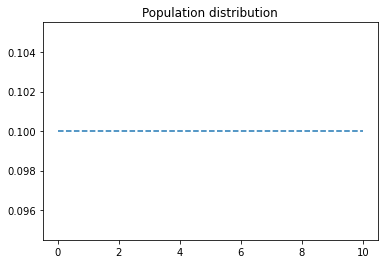

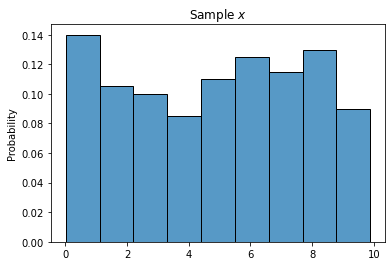

Estimate of statistic on "sample" is: 4.925007914319688


In [26]:
# for the unknown population distribution, 
# consider a uniform distribution with endpoints 0 and 10
pop_distr = stats.uniform(scale=10)
# plot the pdf of the distribution
x = np.linspace(pop_distr.ppf(0.001),pop_distr.ppf(0.999), 1000)
plt.plot(x, pop_distr.pdf(x), '--')
plt.title('Population distribution')
plt.show()

# take a sample from the population
# this will be our fixed, known, sample that we use for bootstrapping
sample_size = 200
sample = pop_distr.rvs(sample_size)
# plot the sample with seaborn displot
sns.histplot(sample,stat='probability')
plt.title('Sample $x$')
plt.show()

# our statistic is the IQR
# let's define a function handle for that
my_stat = lambda sample : stats.iqr(sample)

# note that the true IQR of U(0,10) is of course 5 
# (because the 75-th percentile is 7.5 and 25-th percentile is 2.5)

# this is our sample estimate of the statistic
theta_hat_est = my_stat(sample)
print('Estimate of statistic on "sample" is: '+str(theta_hat_est))

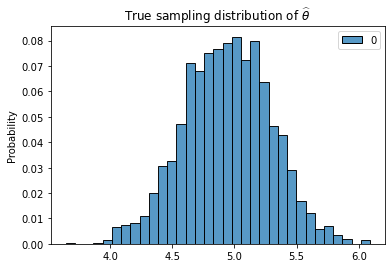

In [27]:
# let's now derive (an empirical approximation of) the true sampling distribution of our statistic
# by drawing fresh samples from the population distribution 
# (note that we can't do this in reality, here is just for the sake of the example)

# let's draw 2000 samples
sample_num = 2000

# initialize a numpy array of size (sample_num, 1) to store the sample statistics
theta_hats = np.empty([sample_num, 1])

# draw the samples by calling the rvs function
for i in range(sample_num):
    # apply our statistic function to a random sample drawn from the pop distr
    theta_hats[i] = my_stat(pop_distr.rvs(sample_size))
    
    
# plot the sampling distribution
sns.histplot(theta_hats, stat='probability')
plt.title('True sampling distribution of $\widehat{\\theta}$')
plt.show()

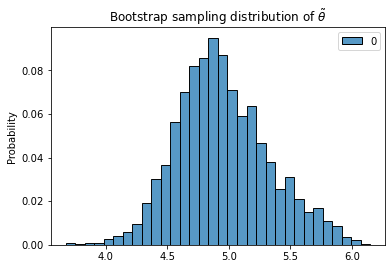

In [28]:
# now let's compute the bootstrap proxy of the sampling distribution
# by resampling our sample (the only thing we know)

# let's define a useful function handle for resampling
# rng is numpy's random number generator
rng = np.random.default_rng()
resample = lambda sample, n : rng.choice(a=sample,size=n)

# draw bootstrap samples, and store corresponding statistic values
theta_tildes = np.empty([sample_num, 1])

for i in range(sample_num):
    # apply our statistic function to a bootstrap resample drawn from the given sample
    theta_tildes[i] = my_stat(resample(sample=sample, n=sample_size))

# plot the bootstrap sampling distribution
sns.histplot(theta_tildes, stat='probability')
plt.title('Bootstrap sampling distribution of $\\tilde{\\theta}$')
plt.show()

### Bootstrap confidence intervals

In [29]:
# now let's derive a 99%-CI estimate with the empirical bootstrap method
alpha = 0.01
CI_left = 2*theta_hat_est - np.percentile(a=theta_tildes,q=100*(1-alpha/2))
CI_right = 2*theta_hat_est + np.percentile(a=theta_tildes,q=100*(alpha/2))
print("99%-CI estimate for the IQR (empirical bootstrap): "+str([CI_left,CI_right]))

99%-CI estimate for the IQR (empirical bootstrap): [3.9042688250770086, 13.872902895497397]


Note that the interval is quite imprecise (large). In some cases, like this one, the percentile bootstrap method might work better

In [30]:
# percentile CI method
# recall, we just pick the percentiles of the bootstrap distributions that cover  the central 1-\alpha probability
CI_perc = np.percentile(a=theta_tildes,q=[100*(alpha/2), 100*(1-alpha/2)])
print("99%-CI estimate for the IQR (percentile bootstrap): "+str(CI_perc))

99%-CI estimate for the IQR (percentile bootstrap): [4.02288707 5.945747  ]


### Bootstrap p-values

* Recall that we can "simulate" the unknown null distribution by shifting the bootstrap distribution by $\theta_0+\hat{\theta}(x)$, where $\theta_0$ is the null value and $\hat{\theta}(x)$ is the estimate of the statistic on our sample $x$
    * and with the null distribution, we can compute p-values
* We will compute a two-sided p-value for the null hypothesis that the true value of the statistic is 5 (which we know it's the true IQR value)
    * we expect a high p-value, so we shouldn't be able to reject the null

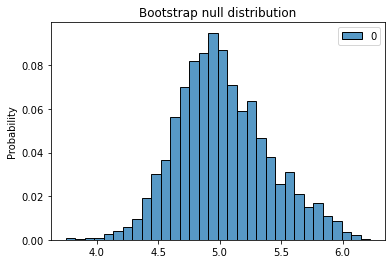

bootstrap two-sided p-value is: 0.8565717141429285


In [31]:
# null value
theta_0 = 5
# let's simulate the null distribution by shifting our bootstrap sampling distribution
bootstrap_null = theta_tildes + (theta_0-theta_hat_est)
# plot it
sns.histplot(bootstrap_null, stat='probability')
plt.title('Bootstrap null distribution')
plt.show()

# compute a two-sided p-value
# we derive the p-values for each side first (with the +1 correction)
left_pval = (np.sum(bootstrap_null<=theta_hat_est)+1)/(bootstrap_null.size + 1)
right_pval = (np.sum(bootstrap_null>=theta_hat_est)+1)/(bootstrap_null.size + 1)

bootstrap_pval = 2*np.min([left_pval,right_pval])
print("bootstrap two-sided p-value is: "+str(bootstrap_pval))

The obtained p-value is very high, which supports the null hypothesis that 5 is the true value of our statistic